%%latex

\textbf{\large Technical test for Junior Data Scientist position at Datrik Intelligence}

\textbf{\normalsize Antonio Ortega}

# Prepare environment

## Load libraries

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os.path
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

## Utility functions 

In [2]:
def plot_roc(y_train, y_predict_train_bin, y_test, y_predict_test_bin):
  lw=2
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  fpr[0], tpr[0], _ = roc_curve(y_true=y_train, y_score = y_predict_train_bin)
  roc_auc[0] = auc(fpr[0], tpr[0])
  fpr[1], tpr[1], _ = roc_curve(y_true=y_test, y_score = y_predict_test_bin)
  roc_auc[1] = auc(fpr[1], tpr[1])
  cols = ['darkorange', "yellow"]
  datasets = ["Train", "Test"]
  plt.figure()
  for i in range(2):
    plt.plot(fpr[i], tpr[i], color=cols[i],
             lw=lw, label='%s (area = %0.2f)' % (datasets[i], roc_auc[i]))

  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic (ROC)')
  plt.legend(loc="lower right")
  plt.show()

## Load datasets

In [36]:
x_train_mca = pd.read_csv(os.path.join("proc_data", "x_train_mca_full.csv"), dtype=np.float64)
x_train = pd.read_csv(os.path.join("proc_data", "x_train.csv"), dtype=np.float64)
x_train = pd.concat([x_train, x_train_mca.filter(like='MCA_')], axis=1)

x_pred_mca = pd.read_csv(os.path.join("proc_data", "x_test_mca_full.csv"))
x_pred = pd.read_csv(os.path.join("proc_data", "x_test.csv"), dtype=np.float64)
x_pred = pd.concat([x_pred, x_pred_mca.filter(like='MCA_')], axis=1)

y_train = pd.read_csv(os.path.join("proc_data", "y_train.csv"))
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.33, random_state=42)

## Overview of the input data

In [4]:
print("{} features loaded".format(X_train.columns.values.shape[0]))
feature_count = np.unique([e.replace(".", "_").split("_")[0] for e in X_train.columns.values.tolist()], return_counts=True)
pd.DataFrame({"feature":feature_count[0], "count": feature_count[1]}).T

815 features loaded


,0,1,2,3,4,5,6,7,8,9
feature,MCA,binary,counter,edad,et,farmaco,nominal,ordinal,raza,sexo
count,5,3,7,1,719,21,51,2,5,1


## Scale the dataset
This is carried out in order to give the same importance to all variables, as *a* *priori* we do not know anything about the label and thus cannot state any feature should be more important than any other. 

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Linear regression model

## Fit (train) the best model to the training set
Use the implemented Ridge Classifier model from scikit-learn. Perform grid search 5-fold cross-validation to obtain a robust AUC estimate while selecting the best alpha (penalizing factor over linear weights). Try values [0,1,5,7,9,10]

In [6]:
ridge = RidgeClassifier(max_iter=2000)
parameters = {"alpha": [0, 1, 5, 7, 9, 10]}
ridge_cv = GridSearchCV(estimator=ridge, param_grid=parameters, cv=5)

In [7]:
ridge_cv.fit(X_train, y_train.Y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=2000, normalize=False, random_state=None, solver='auto',
        tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0, 1, 5, 7, 9, 10]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

## Show the best performing model as resulting from CV 

In [8]:
ridge_cv.best_estimator_

RidgeClassifier(alpha=10, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=2000, normalize=False, random_state=None, solver='auto',
        tol=0.001)

## Exploit (predict) the trained model in the training and test sets

In [53]:
y_predict_train = ridge_cv.predict(X_train)
y_predict_train_bin = np.round(y_predict_train)
print("Accuracy score (train): {0:.3f}".format(accuracy_score(y_train, y_predict_train_bin, normalize=True, sample_weight=None)))
print("AUC score (train): {0:.3f}".format(roc_auc_score(y_train, y_predict_train_bin)))

y_predict_test = ridge_cv.predict(X_test)
y_predict_test_bin = np.round(y_predict_test)
print("Accuracy score (test): {0:.3f}".format(accuracy_score(y_test, y_predict_test_bin, normalize=True, sample_weight=None)))
print("AUC score (test): {0:.3f}".format(roc_auc_score(y_test, y_predict_test_bin)))

Accuracy score (train): 0.647
AUC score (train): 0.637
Accuracy score (test): 0.635
AUC score (test): 0.626


## Display ROC curve for both sets

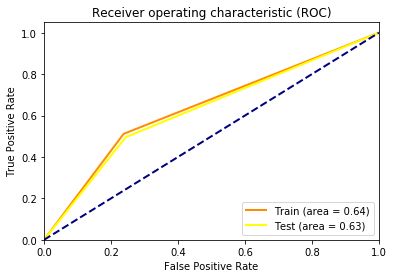

In [54]:
plot_roc(y_train, y_predict_train_bin, y_test, y_predict_test_bin)

## Save predictions of true test (pred) to separate file

In [55]:
prediction = pd.DataFrame(data = ridge_cv.predict(x_pred), index = x_pred.index, columns=["prediccion"])
prediction.index.names = ['identificador']
prediction.to_csv(os.path.join("predictions", "linear_classifier.csv"))

# Gradient Boosting model

## Fit (train) the best model to the training set
Use the implemented Gradient Boosting Classifier model from scikit-learn. Perform grid search 5-fold cross-validation to obtain a robust AUC estimate while selecting the learning rate (the strength of the update), the maximum number of features (how many branches are possible at each split)  and the maximum number of leafs (constraints the size of the tree and is traded off by the number of trees).

In [11]:
gb = GradientBoostingClassifier(random_state = 0, subsample = 0.9, n_estimators=500)
param_grid = dict(
    learning_rate = [0.05, 0.1, 0.3],
    max_features=[1,5,10],
    max_leaf_nodes = [2,3,4])
gb_cv = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5, verbose=True,n_jobs=2)

In [12]:
gb_cv.fit(X_train_scaled, y_train.values.reshape((-1,)))

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  6.7min
[Parallel(n_jobs=2)]: Done 180 out of 180 | elapsed: 26.3min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=0.9, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'learning_rate': [0.05, 0.1, 0.3, 0.5], 'max_features': [1, 5, 10], 'max_leaf_nodes': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

## Show the best performing model as resulting from CV 

In [18]:
gb_cv.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=10, max_leaf_nodes=4, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=500, n_iter_no_change=None, presort='auto',
              random_state=0, subsample=0.9, tol=0.0001,
              validation_fraction=0.1, verbose=0, warm_start=False)

## Exploit (predict) the trained model in the training and test sets

In [113]:
y_predict_train = gb_cv.predict_proba(X_train_scaled)[:,1]
y_predict_train_bin = np.round(y_predict_train)
print("Accuracy score (training): {0:.3f}".format(
        accuracy_score(y_train, y_predict_train_bin, normalize=True, sample_weight=None)
    ))
print("AUC score (training): {0:.3f}".format(roc_auc_score(y_train, y_predict_train_bin)))

y_predict_test = gb_cv.predict_proba(X_test_scaled)[:,1]
y_predict_test_bin = np.round(y_predict_test)
print("Accuracy score (test): {0:.3f}".format(
        accuracy_score(y_test, y_predict_test_bin, normalize=True, sample_weight=None)
    ))
print("AUC score (test): {0:.3f}".format(roc_auc_score(y_test, y_predict_test_bin)))
# print("Learning rate: ", learning_rate)
# print("Accuracy score (training): {0:.3f}".format(gb.score(X_train_scaled, y_train)))
# print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test_scaled, y_test)))

Accuracy score (training): 0.654
AUC score (training): 0.643
Accuracy score (test): 0.645
AUC score (test): 0.635


## Display ROC curve for both sets

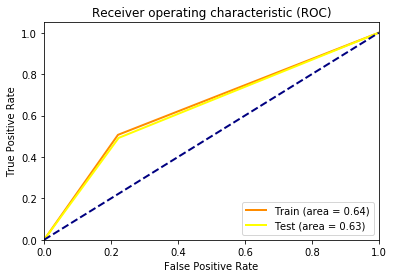

In [20]:
plot_roc(y_train, y_predict_train_bin, y_test, y_predict_test_bin)

## Save predictions of true test (pred) to separate file

In [41]:
prediction = pd.DataFrame(data = gb_cv.predict_proba(x_pred)[:,1], index = x_pred.index, columns=["prediccion"])
prediction.index.names = ['identificador']
prediction.to_csv(os.path.join("predictions", "gradient_boosting.csv"))

# Discussion
While both models achieve similar AUC scores, around 0.64, they are far from perfect and couldbe improved. As mentioned in the EDA, further data engineering prior to model training could make this process easier. Moreover, models with more capacity (i.e. more iterations, etc) or more complex (neural networks) could have been developed but were not due to computing power capacity, time and the scope of the project. Some of the frameworks offering such models are keras and PyMC3. PyMC3 is a probabilistic programming framework that could have been used here to return a bayesian estimate (true probability based on model and data) of the label being 1.

The models have nevertheless partially captured the function connecting the input features to the target label.